For this project, I'm going to explore time series forcasting techniques on a dataset that looks specifically at demands for specific products

The dataset has been taken from https://www.kaggle.com/felixzhao/productdemandforecasting

In [1]:
%matplotlib inline

import pandas as pd
from pandas import read_csv
from pandas import datetime

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('HistoricalProductDemand.csv')

In [3]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [4]:
df.tail()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50
1048574,Product_0704,Whse_J,Category_001,2016/6/27,4


In [5]:
print(df.dtypes)

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object


I want use various time series methods to perform analysis on the demand for specific products. I'm going to first organize the data by product for easier visualization

In [6]:
df = df.sort_values('Product_Code')
df.head()

For time series analysis, I will need the date to be of type dateTime. To do this I'll use the pd.to_dateime() command

In [7]:
df["Date"]= pd.to_datetime(df["Date"]) 

In [8]:
df.columns

Index([u'Product_Code', u'Warehouse', u'Product_Category', u'Date',
       u'Order_Demand'],
      dtype='object')

For different time series forcasting methods that use various features as prediction tools, I'm going to create new fields for day, month, and year that can be fed for the data. This should help the accuracy of my models if the data really is fit for a time series analysis.

In [9]:
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
day                        float64
month                      float64
year                       float64
dtype: object

My Demand needs to be an int to use the various sci-kit learn packages. To do that I'll convert it from an object datatype to an int.

In [25]:
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')
df.dtypes
df = df.dropna()
df['Order_Demand'] = df['Order_Demand'].astype(int)

I'm using a labelEconder to create numeric inputs for my features. This is necessary to use the various features in scikit learn packages.

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Product_Code'])
df['Product_Code'] = le.transform(df['Product_Code'])
le.fit(df['Warehouse'])
df['Warehouse'] = le.transform(df['Warehouse'])
le.fit(df['Product_Category'])
df['Product_Category'] = le.transform(df['Product_Category'])

In [27]:

from sklearn.model_selection import train_test_split
Y = df['Order_Demand']
X = df[['Product_Code', 'Product_Category', 'Warehouse', 'day', 'month', 'year']]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.20, 
                                                    random_state=42)

The first tool I will use is RandomForest. I've used this in two previous Data Science projects and am familair, and will be a good comparison tool with the Gradient boosting model I'll do later

In [88]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
model = rf.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)
print(rf.score(X_test, y_test))

0.0215412649413


I've gotten some pretty awful accuracy using random forrest on this data. Honestly I'm not too surprised, random forrest is typically used for classification or linear regression and doesn't seem to fit the problem at hand very well.

Next I will try Gradient Boosting. This is one of the techniques we discussed in class, and should provide a better prediction accuracy than randome forrest.

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
model = gbr.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)
print(gbr.score(X_test, y_test))

0.184670734716


The accuracy for Gradient Boosting has proven to be better than randomforrest, as expected, but the accuracy still is not great. 

Another approach discussed in class in regards to time series forecasting was linear regresssion. I am going to try a linear regression model on the data to see if it provides any basic analysis for the dataset. I do not expect great resuts out of a linear regression model, but It will be interesting to visualize.

In [96]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.0078152714165622417

In [97]:
model.coef_

array([  1.20662345e+00,   2.06187436e+02,   2.30226873e+03,
        -5.69678142e+00,  -3.98700459e+00,   1.97881140e+02])

In [98]:
model.intercept_

-401721.92986863141

Text(0,0.5,u'Predicted Demand: $\\hat{Y}_i$')

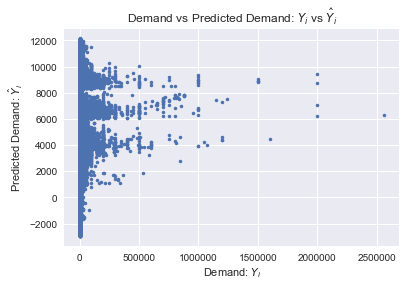

In [99]:
model.predict(X_test)
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')
plt.title("Demand vs Predicted Demand: $Y_i$ vs $\hat{Y}_i$")
plt.xlabel("Demand: $Y_i$")
plt.ylabel("Predicted Demand: $\hat{Y}_i$")

The accuracy for linear regression was pretty awful for this product, but honestly that was expected. The visualization of the Demand vs Predicted Demand has no sort of pattern, and is honestly rather random.

In [60]:
df2 = df.sort_values('Date')

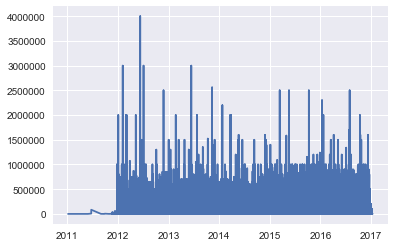

In [61]:
plt.plot(df2["Date"], df2["Order_Demand"])
plt.show()

Time series forcasting looks to predict specifically on the time variable. Since we are predicting demand based off of time. Graphing the two variables will give us a decent understanding of general trends. Based off the graph, we see seasonal trends in the demand, with a burst in demand in 2012. Aside from that one burst, the mean seems to remain steady for the demand of the first product (the product we have been assessing throughout this notebook)

In [62]:
df2 = df.sort_values('Product_Code')
df2.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,day,month,year
604464,0,2,4,2014-04-23,100,23.0,4.0,2014.0
598573,0,2,4,2014-06-02,2300,2.0,6.0,2014.0
356777,0,2,4,2013-05-24,100,24.0,5.0,2013.0
902287,0,0,4,2016-07-14,3300,14.0,7.0,2016.0
930940,0,2,4,2016-07-07,300,7.0,7.0,2016.0


Since we are predicting demand for product 1, we are dropping the cells with the other products as they won't help us with the desired prediction.

In [63]:
df2 = df2.loc[ (df2["Product_Code"] == 0) ]


For many time series analysis techniques, we need the data solely in terms of the time and the variable we are predicting. Because of that we are going to minimize the dataset so it only contains the demand and the date.

In [64]:
df2 = df.sort_values('Date')

In [65]:
df2 = df2.drop('Product_Code', 1)

In [66]:
df2 = df2.drop('Warehouse', 1)

In [67]:
df2 = df2.drop('Product_Category', 1)

In [68]:
df2 = df2.drop('day', 1)
df2 = df2.drop('month', 1)
df2 = df2.drop('year', 1)

In [70]:
df2.head()

,Date,Order_Demand
44799,2011-01-08,2
72252,2011-05-31,108
8432,2011-06-24,7000
8431,2011-06-24,85000
72669,2011-09-02,1250


In [71]:
df2.columns

Index([u'Date', u'Order_Demand'], dtype='object')

In [72]:
df2.dtypes

Date            datetime64[ns]
Order_Demand             int64
dtype: object

I've been struggling to get the ARIMA model to work on this data. As a future project, I will revisit this notebook and try to forcast using ARIMA.